## Roll-out on a Full Image
### Introduction
Applying machine learning models to entire, full-sized images—especially in the realm of image processing—presents a distinct set of challenges and opportunities. Such a "roll-out" doesn't just involve stretching a model's capabilities across larger pixel dimensions; it tests the model's capacity to consistently and correctly generate outputs, be it segmentation or classification maps, across varying regions of an image.

### Preparation
- Here, we need to process the image to be rolled-out into the shape that is compatible to our model input shape. For example, the model input shape is `(3, 3, 21)`. The below code is for processing the data.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.6 MB/s eta 0:00:00


### Model Application
In this phase, the trained model processes the entire image, generating outputs that classify the different regions into respective categories such as sea-ice and leads. Let's say your saved model is called `cnn_model` or `vit_model`. You can load in different models you have trained in Week 2.

## Load in CNN

In [3]:
import tensorflow as tf
# Load in trained CNN model
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/0069/week2/modelCNN_test3_100epo.h5')
# cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/GEOL0069/2324/Week_2/modelCNN_test3.h5')




## Load in ViT

In [4]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.saving import register_keras_serializable

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def mlp(x, hidden_units, dropout_rate):
   for units in hidden_units:
       x = layers.Dense(units, activation=tf.nn.gelu)(x)
       x = layers.Dropout(dropout_rate)(x)
   return x

@register_keras_serializable()
class Patches(layers.Layer):
   def __init__(self, patch_size, **kwargs):
       super().__init__(**kwargs)
       self.patch_size = patch_size

   def call(self, images):
       batch_size = tf.shape(images)[0]
       patches = tf.image.extract_patches(
           images=images,
           sizes=[1, self.patch_size, self.patch_size, 1],
           strides=[1, self.patch_size, self.patch_size, 1],
           rates=[1, 1, 1, 1],
           padding="VALID",
       )
       patch_dims = patches.shape[-1]
       patches = tf.reshape(patches, [batch_size, -1, patch_dims])
       return patches

   def get_config(self):
       config = super().get_config()
       config.update({"patch_size": self.patch_size})
       return config

@register_keras_serializable()
class PatchEncoder(layers.Layer):
   def __init__(self, num_patches, projection_dim, **kwargs):
       super().__init__(**kwargs)
       self.num_patches = num_patches
       self.projection_dim = projection_dim
       self.projection = layers.Dense(units=projection_dim)
       self.position_embedding = layers.Embedding(
           input_dim=num_patches, output_dim=projection_dim
       )

   def call(self, patch):
       positions = tf.range(start=0, limit=self.num_patches, delta=1)
       encoded = self.projection(patch) + self.position_embedding(positions)
       return encoded

   def get_config(self):
       config = super().get_config()
       config.update({
           "num_patches": self.num_patches,
           "projection_dim": self.projection_dim
       })
       return config


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = more_data(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
#=========================================================================================================
#=========================================================================================================
#=========================================================================================================
def run_experiment(model):
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Update the filepath to include `.weights.h5`
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=30,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Load the best weights
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

num_classes = 2 #Can be changed to multi-classed classification
input_shape = (3, 3, 21)#depends on the size of the image we want

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 2
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

# # Data augmentation
# more_data = keras.Sequential(
#     [
#         layers.Normalization(),
#         layers.Resizing(image_size, image_size),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="more_data",
# )
# more_data.layers[0].adapt(X_train)

from tensorflow.keras.models import load_model

# Now load the model
vit_model = load_model('/content/drive/MyDrive/0069/week2/model.keras',
                      custom_objects={'Patches': Patches,
                                    'PatchEncoder': PatchEncoder,
                                      # 'more_data': more_data,
                                    'mlp': mlp})

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


## Load in Random Forest
You can also test Random Forest's performance. The data processing is a bit different for RF so we do it separately below.

In [5]:
import joblib

# Load the model from the file
rf_model = joblib.load('/content/drive/MyDrive/0069/week2/random_forest_model_test.pkl')
print("Model loaded successfully.")


Model loaded successfully.


## Rollout on a Small Region
You can also try your model on a small sub-region of a full image. For example, we do the rollout on a region where we used IRIS to classify. The overall logic is the same.

In [15]:
import numpy as np
# The images are in numpy array format
image = np.load('/content/drive/MyDrive/0069/week2/chunk_3_band_21.npy')


# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [100, 400, 300, 700]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]

# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array ---this is for all the NN approach rollout
x_test_all = np.array(patches)
model1 = cnn_model # You can change this to vit_model
y_pred= model1.predict(x_test_all, batch_size = 250)
y_pred1 = (y_pred > 0.5).astype(int)
map3=y_pred1.reshape(298, 198)


237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


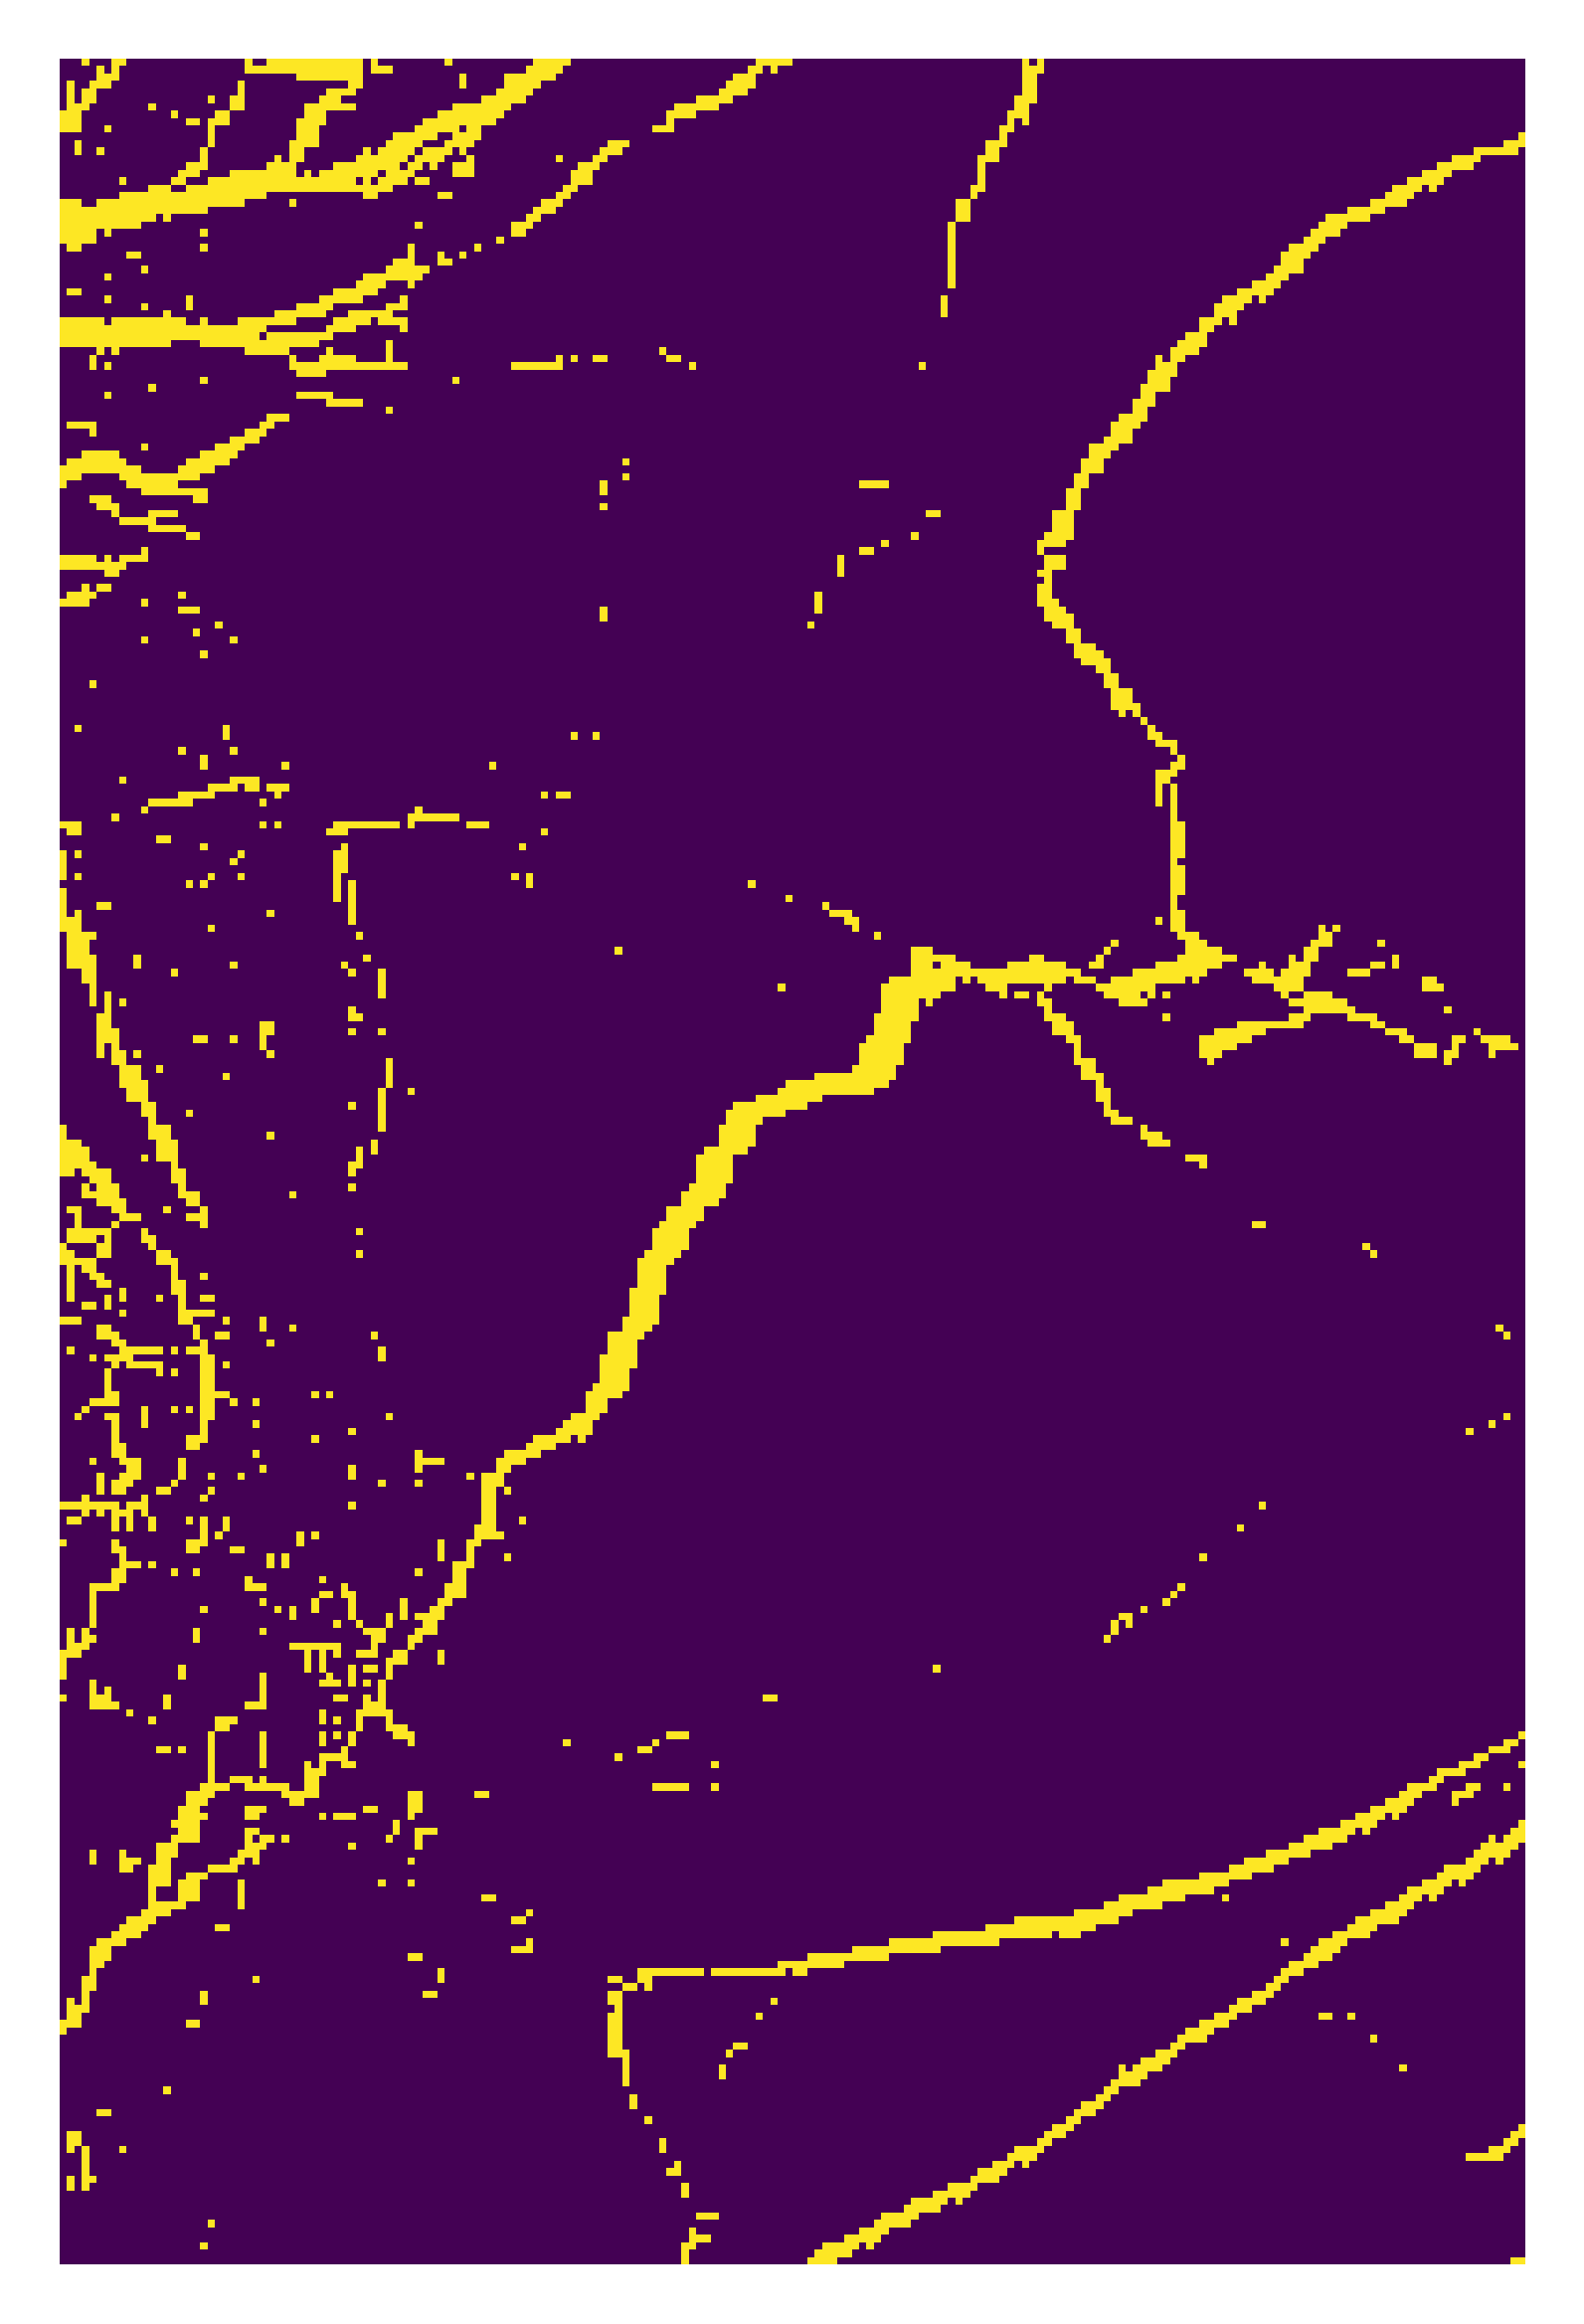

In [16]:
# Display the results
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map3)
save_dir = '/content/drive/MyDrive/0069/week3/'
plt.axis('off')  # Remove axis for a cleaner image
plt.savefig(save_dir + "map3.png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
# For random forest rollout

X_test_reshaped = np.reshape(x_test_all, (x_test_all.shape[0], -1))
y_pred_loaded = rf_model.predict(X_test_reshaped)
map4=y_pred_loaded.reshape(298, 198)

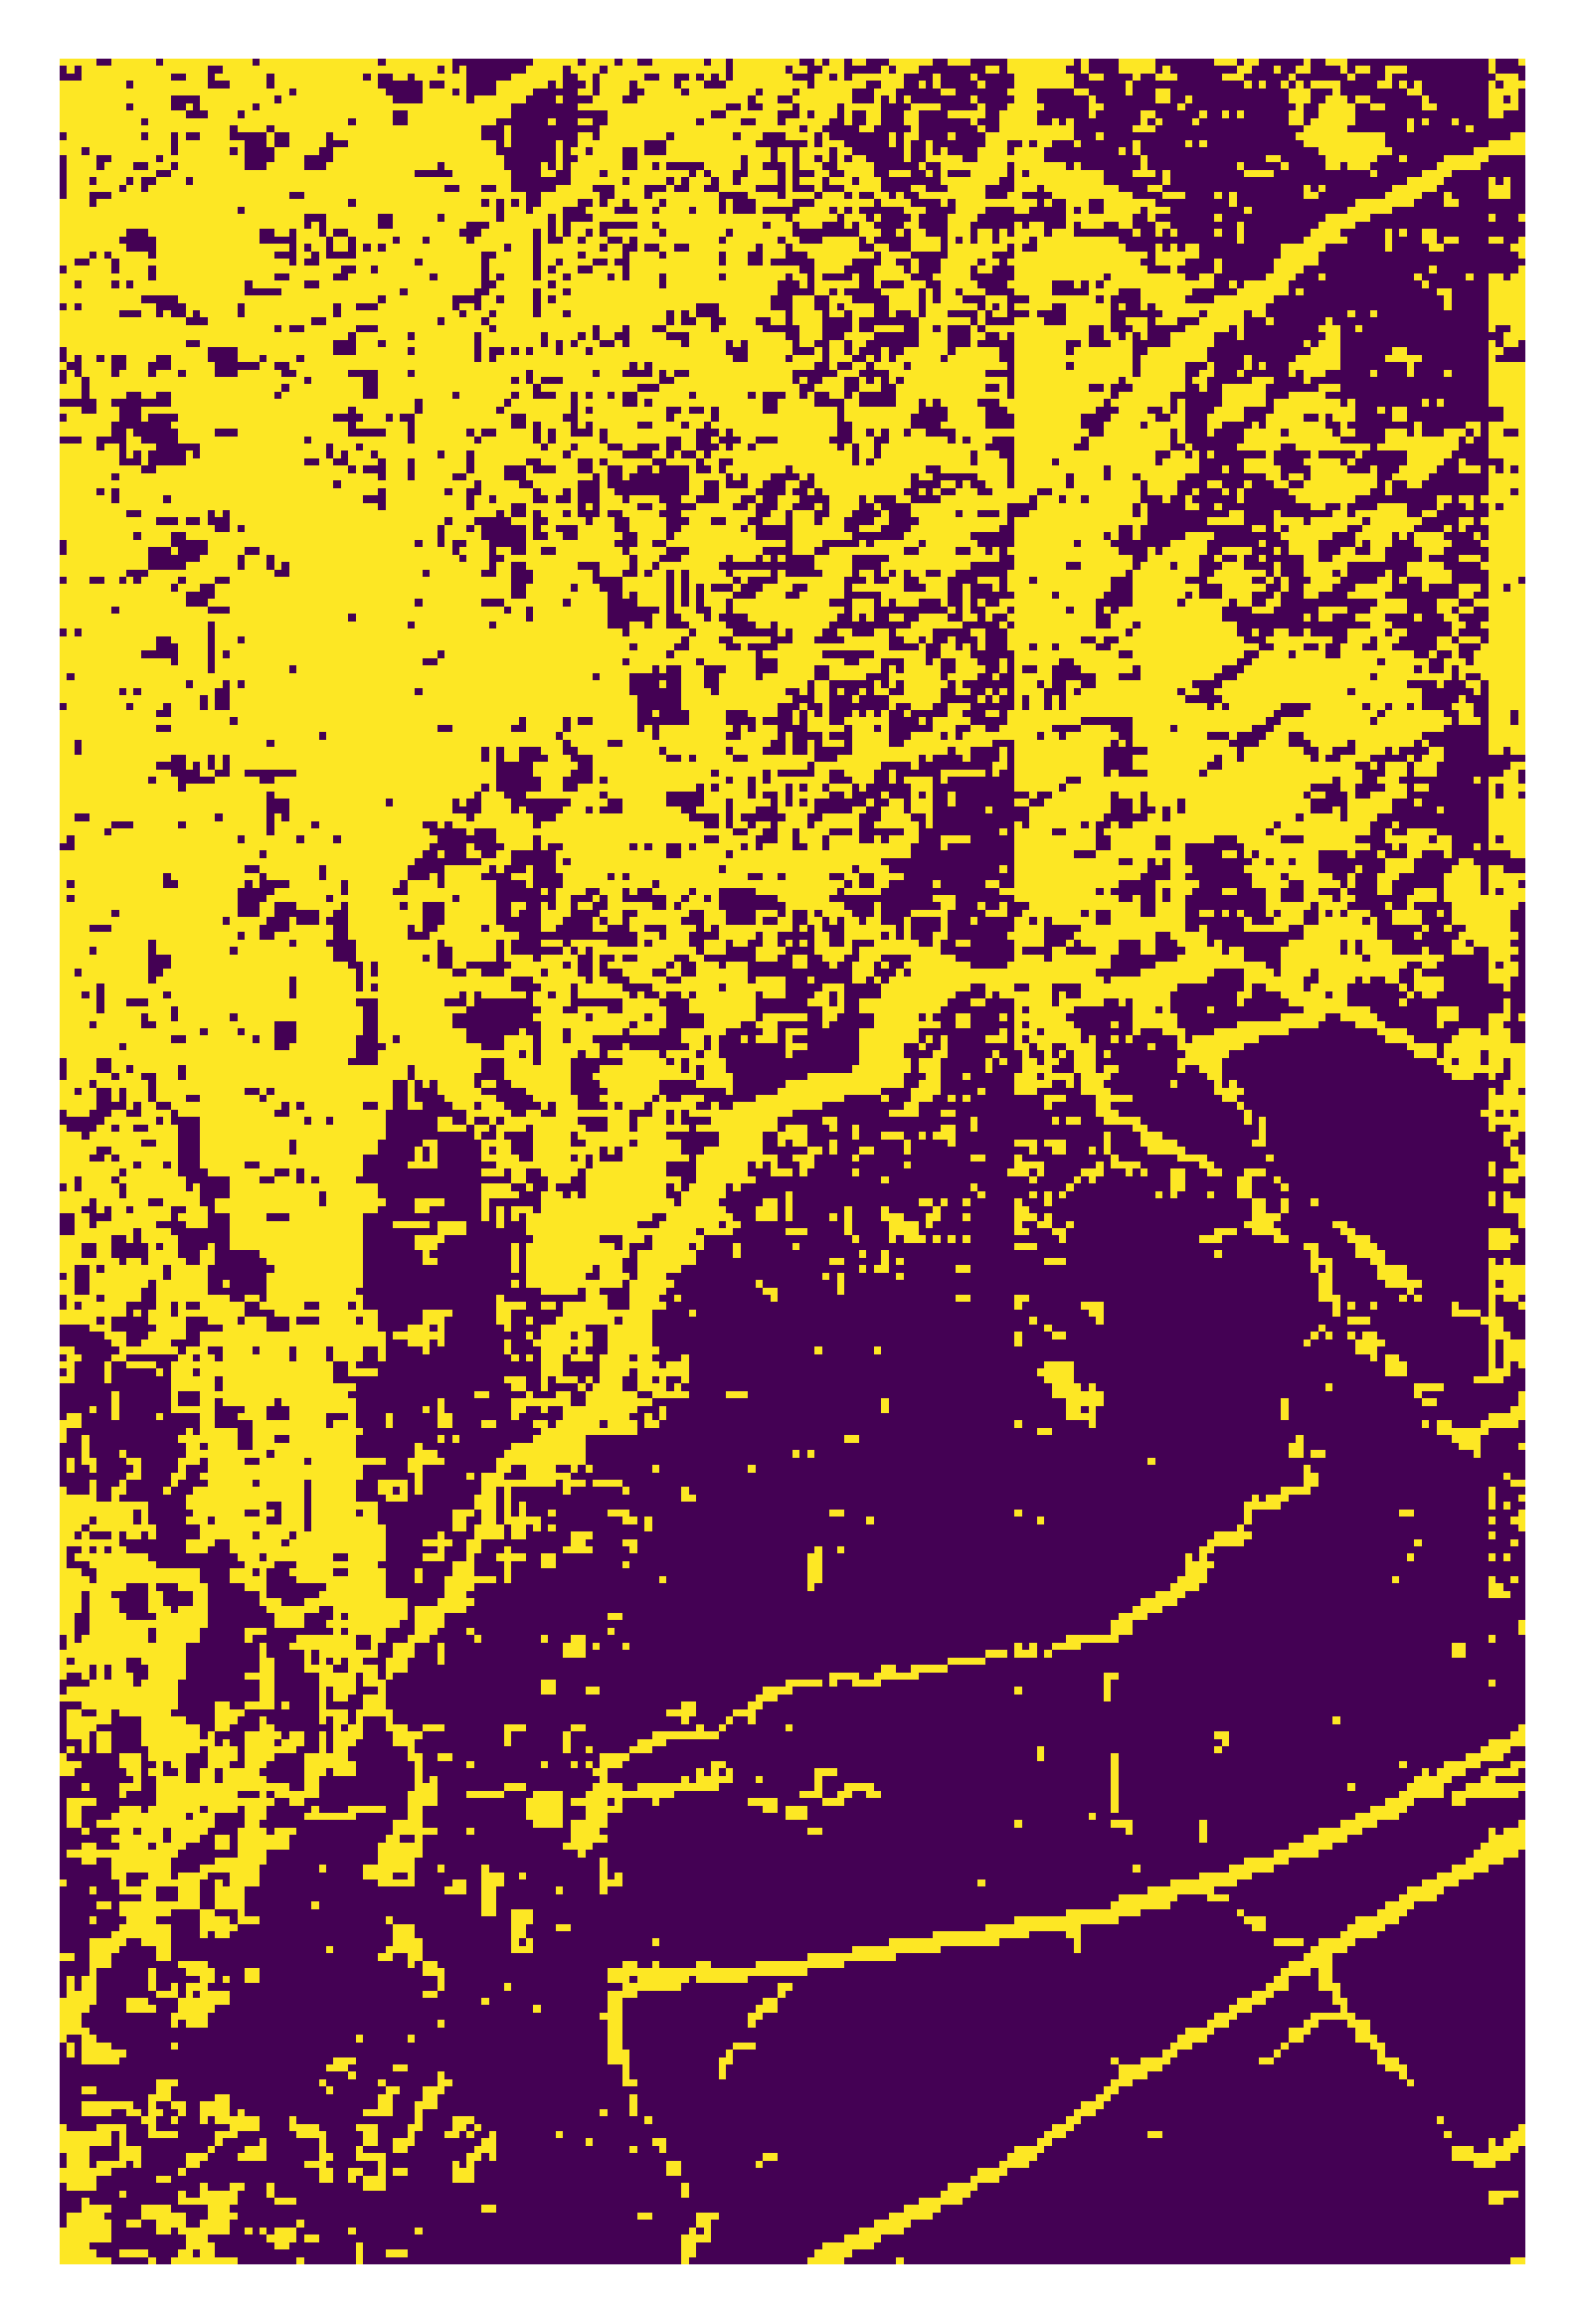

In [18]:
# Alter the view setting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map4)
save_dir = '/content/drive/MyDrive/0069/week3/'
plt.axis('off')  # Remove axis for a cleaner image
plt.savefig(save_dir + "map4.png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [23]:
import numpy as np
import tensorflow as tf
# The images are in numpy array format
image = np.load('/content/drive/MyDrive/0069/week2/chunk_3_band_21.npy')


# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [100, 1000, 300, 1300]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]

# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array ---this is for all the NN approach rollout
x_test_all = np.array(patches)
y_pred = vit_model.predict(x_test_all, batch_size=250)      # logits (N,2)

p1 = tf.nn.softmax(y_pred, axis=1).numpy()[:, 1]            # class-1 prob (N,)
y_class = (p1 > 0.5).astype(int)

map5 = y_class.reshape(298, 198)


237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


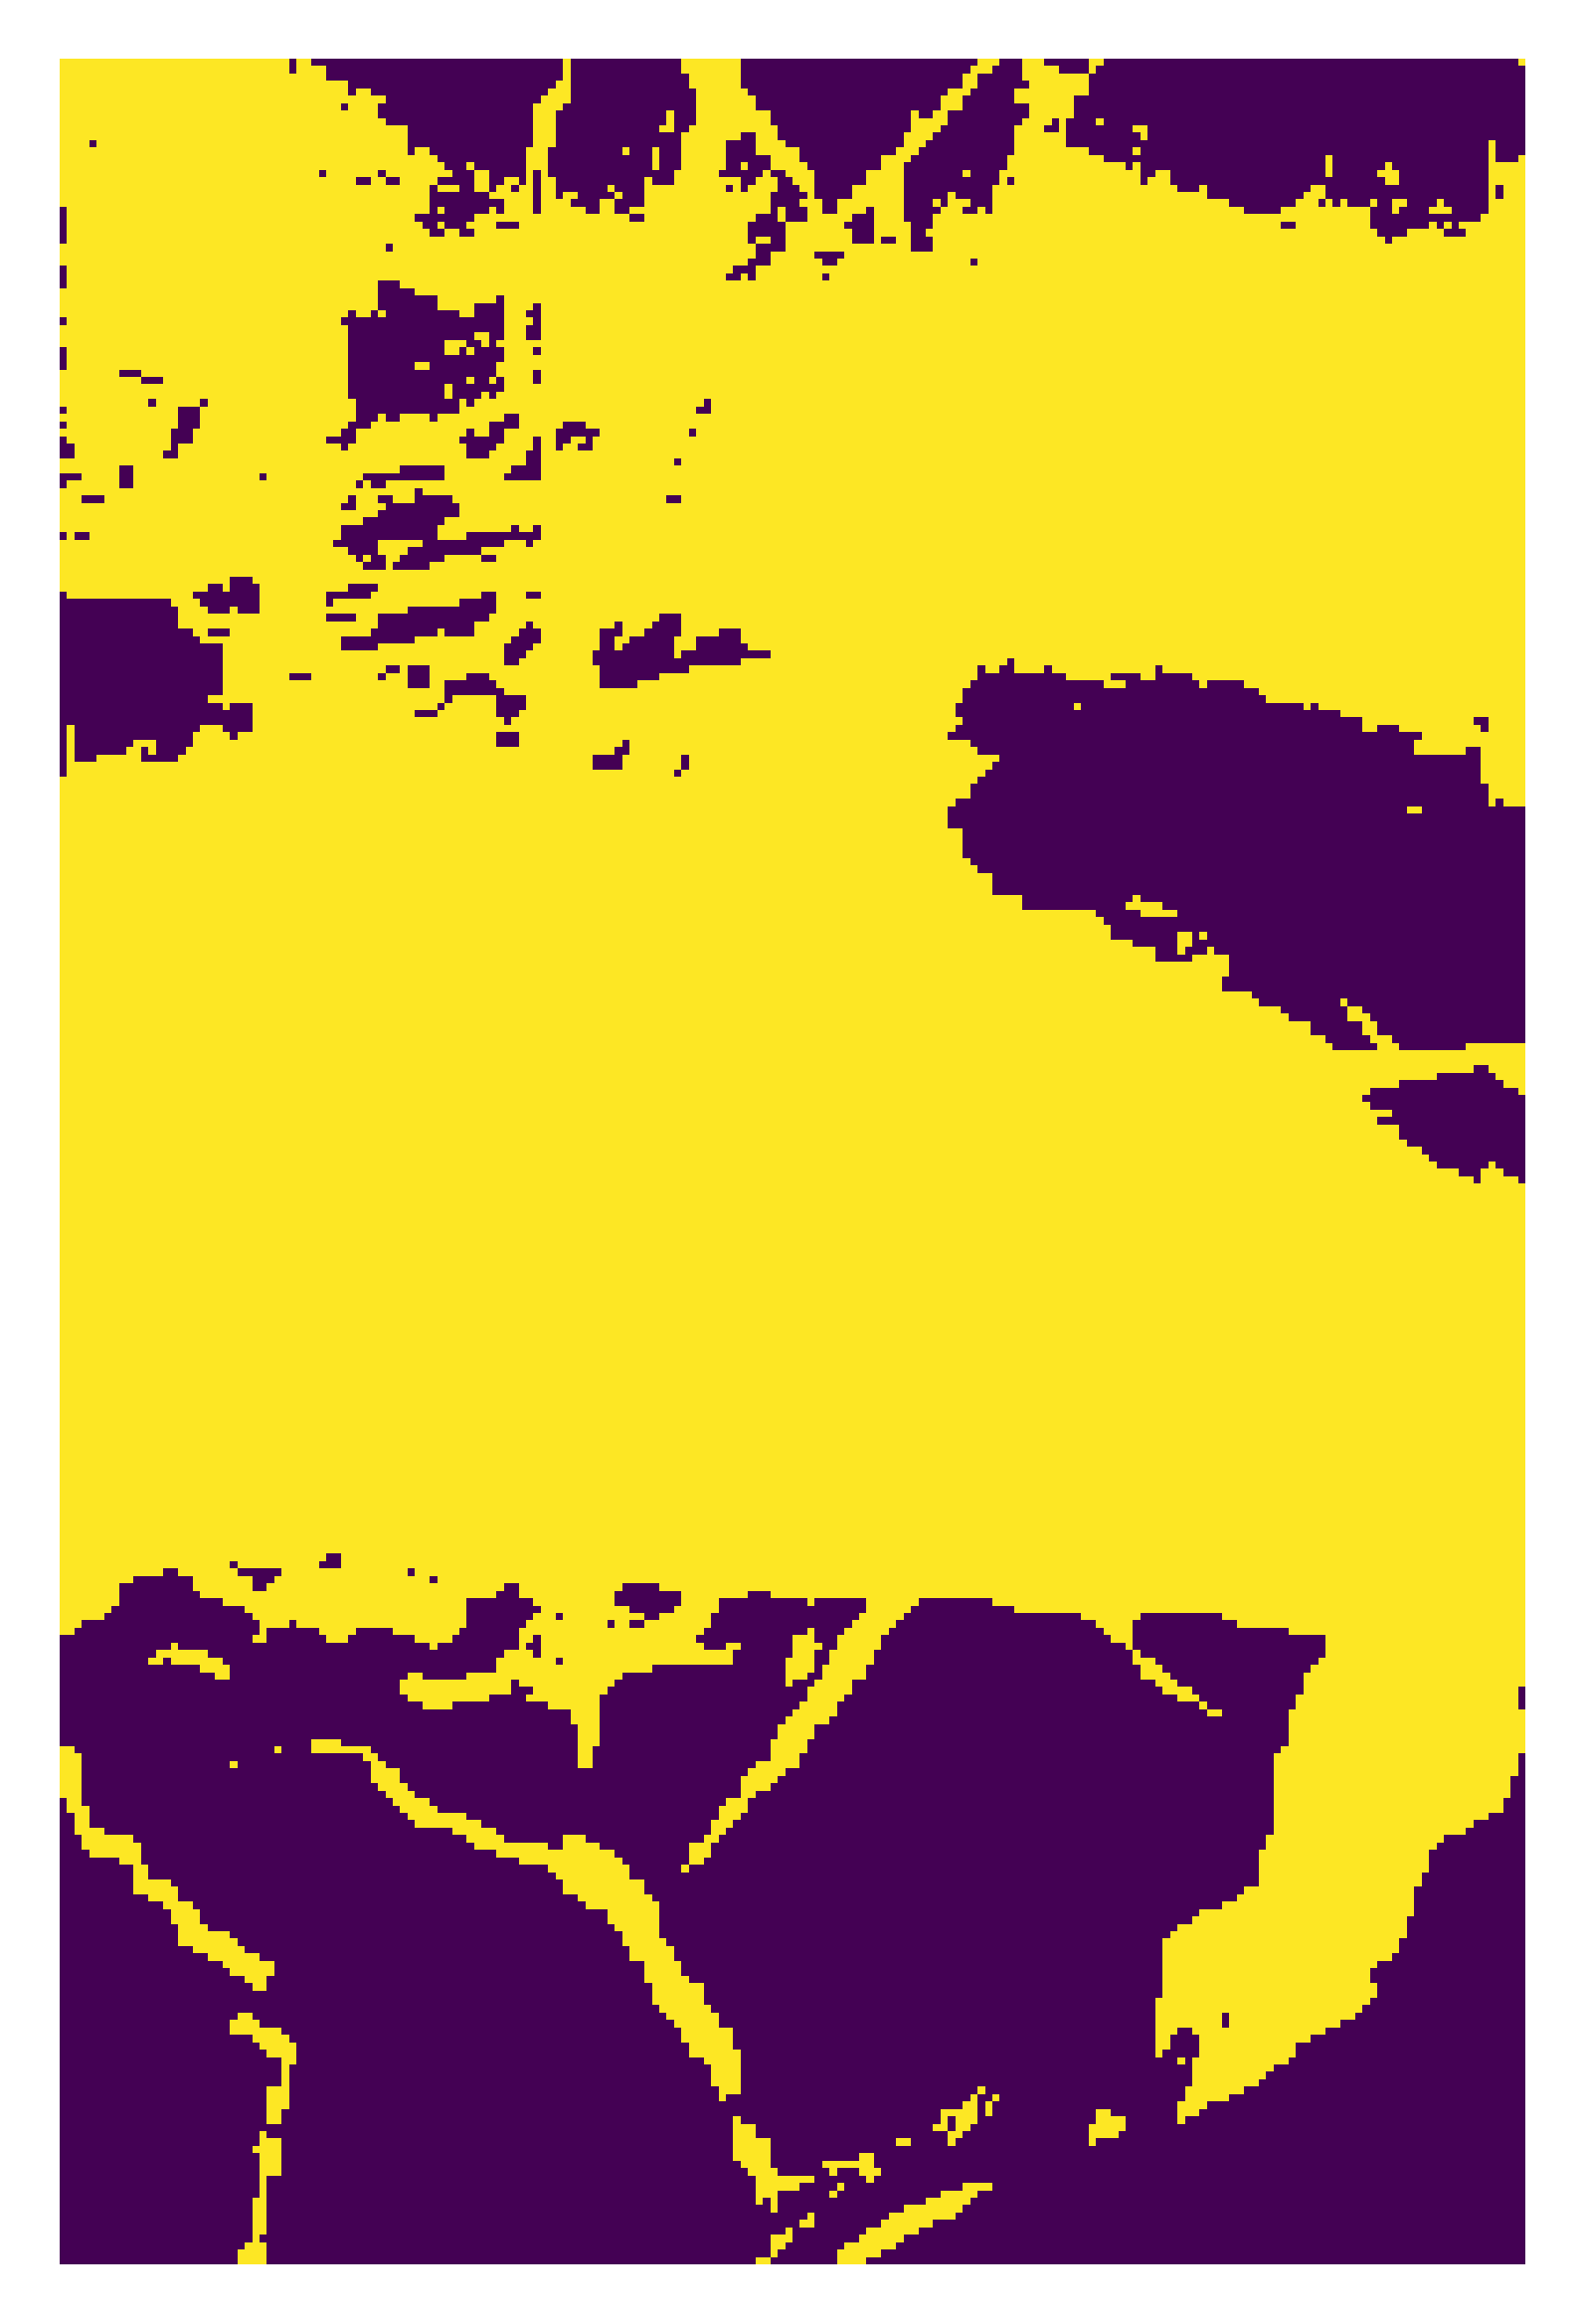

In [24]:
# Display the results
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map5)
save_dir = '/content/drive/MyDrive/0069/week3/'
plt.axis('off')  # Remove axis for a cleaner image
plt.savefig(save_dir + "map5.png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## Rollout on a full region
#### Below contains code to rollout your model on a full region of Sentinel-3 Imagery. This might be difficult to run since we are are free-version of Colab.

In [13]:
# do pip install netCDF4 if needed
import netCDF4
import pyproj
import matplotlib.pyplot as plt
from math import pi
from sklearn.feature_extraction import image
import numpy as np
import os
import h5py # Import h5py

# Function to convert coordinates from WGS84 to EASE-Grid 2.0 projection
def WGS84toEASE2(lon, lat):
    # Initialise the EASE-Grid 2.0 projection
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    # Initialise the WGS84 projection
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    # Transform the coordinates from WGS84 to EASE-Grid 2.0
    x, y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

# Directory setup for data files
directory = '/content/drive/MyDrive/0069/week3/S3A_OL_1_EFR____20180601T013946_20180601T014034_20240530T192600_0048_032_003_1080_MAR_R_NT_004.SEN3/'

# Load in geolocation data using h5py as netCDF4 was having issues with this specific file
try:
    with h5py.File(os.path.join(directory, 'geo_coordinates.nc'), 'r') as hf_geo:
        lat = hf_geo['latitude'][:]
        lon = hf_geo['longitude'][:]
    print("Successfully loaded geo_coordinates.nc with h5py.")
except Exception as e:
    print(f"Error loading geo_coordinates.nc with h5py: {e}")
    raise # Re-raise if h5py also fails

# Load in radiance data for a specific band (Band Oa01) from a NetCDF file
try:
    with h5py.File(os.path.join(directory, 'Oa01_radiance.nc'), 'r') as hf_oa01:
        Oa01_Radiance = hf_oa01['Oa01_radiance'][:]
    print("Successfully loaded Oa01_radiance.nc with h5py.")
except Exception as e:
    print(f"Error loading Oa01_radiance.nc with h5py: {e}")
    raise # Re-raise if h5py also fails

# Convert the longitude and latitude to EASE-Grid 2.0 coordinates
X, Y = WGS84toEASE2(lon, lat)

# Load in additional instrument data from a NetCDF file
OLCI_file_p = directory
try:
    with h5py.File(os.path.join(OLCI_file_p, 'instrument_data.nc'), 'r') as hf_instrument:
        solar_flux = hf_instrument['solar_flux'][:]
        detector_index = hf_instrument['detector_index'][:]
    print("Successfully loaded instrument_data.nc with h5py.")
except Exception as e:
    print(f"Error loading instrument_data.nc with h5py: {e}")
    raise # Re-raise if h5py also fails

solar_flux_Band_Oa01 = solar_flux[0]  # Solar flux for Band Oa01

# Load in tie geometries (e.g., Solar Zenith Angle) from a NetCDF file
try:
    with h5py.File(os.path.join(OLCI_file_p, 'tie_geometries.nc'), 'r') as hf_tie_geometries:
        SZA = hf_tie_geometries['SZA'][:]
    print("Successfully loaded tie_geometries.nc with h5py.")
except Exception as e:
    print(f"Error loading tie_geometries.nc with h5py: {e}")
    raise # Re-raise if h5py also fails

# Initialise lists to store bands and patches
Bands = []
Patches = []

# Calculate the number of patches (nx, ny)
nx = X.shape[0] - 2
ny = X.shape[1] - 2
q = 0

# Process each band
for i in range(1, 22):  # Loop through 21 bands
    solar_flux_Band_Oa01 = solar_flux[q]
    print(i)
    bandnumber = '%02d' % (i)
    band_path = os.path.join(directory, 'Oa'+bandnumber+'_radiance.nc')
    try:
        with h5py.File(band_path, 'r') as hf_oa_temp:
            oa = hf_oa_temp['Oa' + bandnumber + '_radiance'][:]
    except Exception as e:
        print(f"Error loading {os.path.basename(band_path)} with h5py: {e}")
        raise # Re-raise if h5py also fails

    # Note: 'columns' and 'rows' dimensions are usually in instrument_data.nc or the radiance files themselves.
    # Since we're using h5py, we'll try to get them from the Oa01_radiance file for consistency
    # or potentially directly from the oa array if consistent.
    # Assuming dimensions are consistent across bands, we can get them from the first loaded radiance.
    # If instrument_data.nc was successfully loaded with h5py and contains these dimensions, use those.
    # For now, let's assume `Oa01_Radiance` gives us the height and width.
    height, width = Oa01_Radiance.shape[:2] # Adjust if dimensions are not consistent or need to be derived differently.

    # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF)
    TOA_BRF = np.zeros((height, width), dtype='float32')
    angle = np.zeros((TOA_BRF.shape[0], TOA_BRF.shape[1]))
    for x in range(TOA_BRF.shape[1]):
        angle[:, x] = SZA[:, int(x / 64)]

    TOA_BRF = np.pi * np.asarray(oa) / solar_flux_Band_Oa01[detector_index] / np.cos(np.radians(angle))

    Bands.append(TOA_BRF)
    # Extract patches of size 3x3 from the TOA BRF and reshape for further processing
    Patches.append(image.extract_patches_2d(np.array(TOA_BRF), (3, 3)).reshape(nx, ny, 3, 3))
    q += 1

# Convert the list of patches to a NumPy array and reshape for machine learning model input
Patches_array = np.asarray(Patches)
x_test_all = np.moveaxis(Patches_array, 0, -1).reshape(Patches_array.shape[1] * Patches_array.shape[2], 3, 3, 21)


Successfully loaded geo_coordinates.nc with h5py.
Successfully loaded Oa01_radiance.nc with h5py.


/tmp/ipython-input-1154429574.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)


Successfully loaded instrument_data.nc with h5py.
Successfully loaded tie_geometries.nc with h5py.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


### You can make prediction on full image using the code below (for CNN and ViT model)

In [22]:
# Make predictions on the full image
y_pred= vit_model.predict(x_test_all, batch_size = 1000)
y_pred1 = (y_pred > 0.5).astype(int)
# Reshape it for display
map2=y_pred1.reshape(Patches_array.shape[1], Patches_array.shape[2])

5316/5316 ━━━━━━━━━━━━━━━━━━━━ 389s 73ms/step


ValueError: cannot reshape array of size 10630518 into shape (1093,4863)

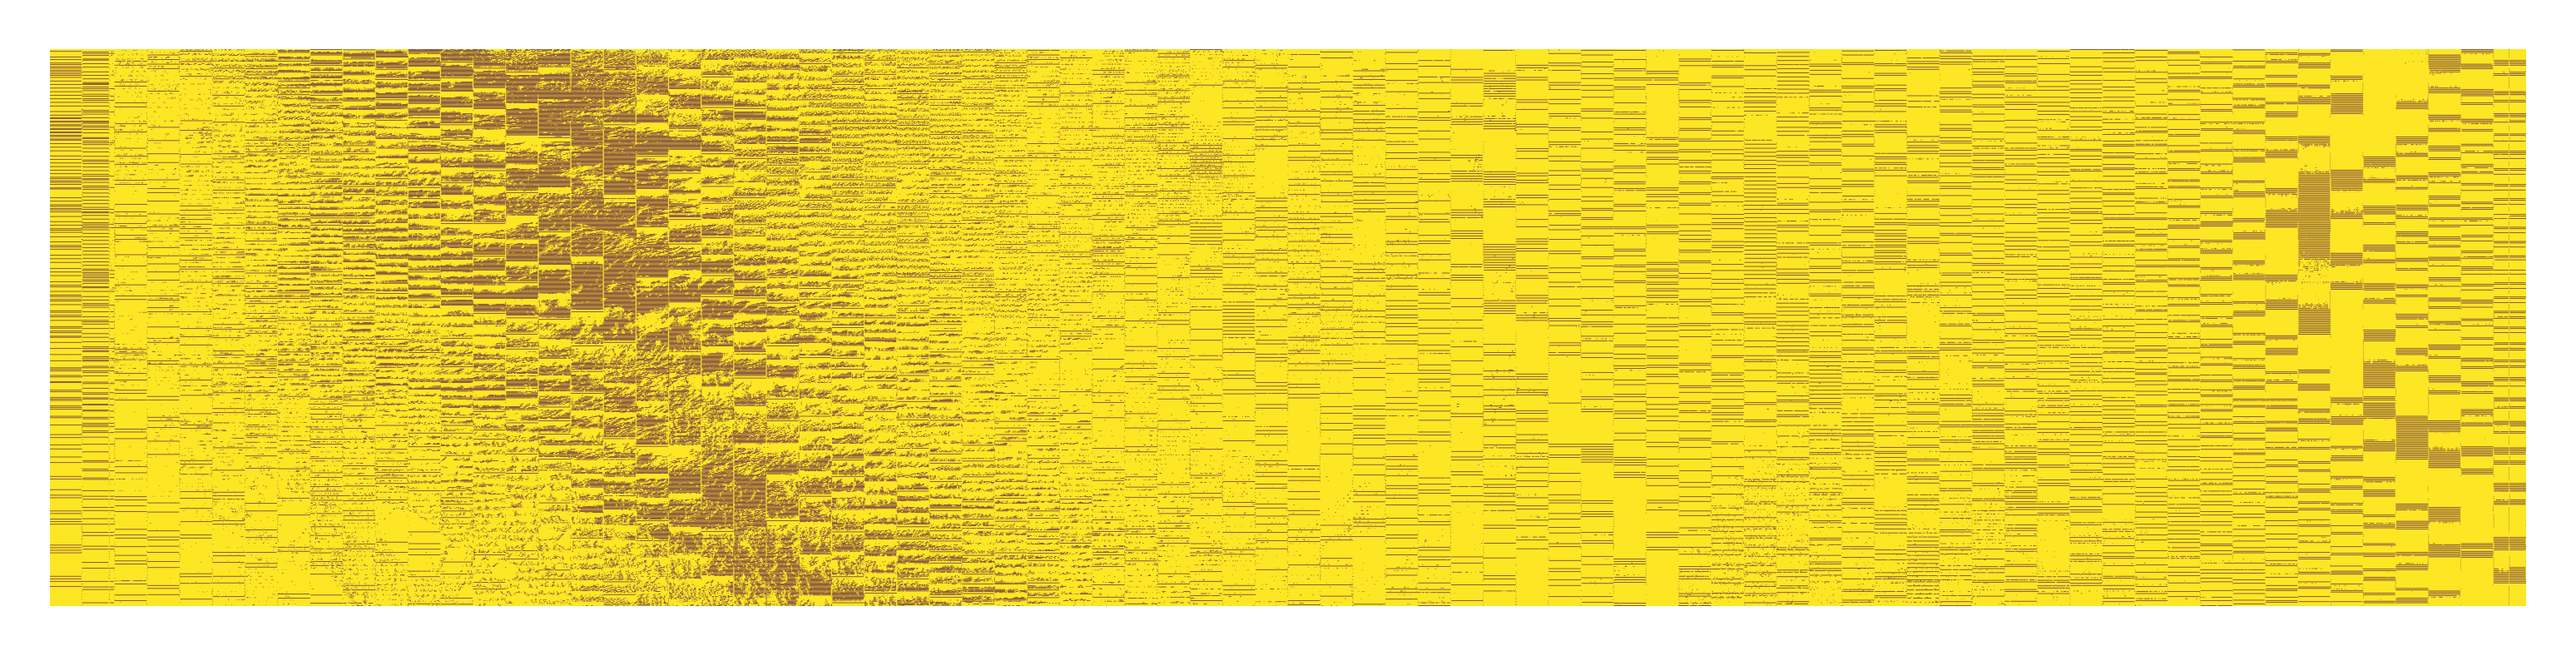

In [21]:
# Display the results
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map2)
plt.axis('off')  # Remove axis for a cleaner image
save_dir = '/content/drive/MyDrive/0069/week3/'
plt.savefig(save_dir + "map2.png", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

For random forest, the code is a bit different but the logic remains the same. Below cell loads makes prediction using the random forest model loaded.

In [ ]:
X_test_reshaped = np.reshape(x_test_all, (x_test_all.shape[0], -1))
y_pred_loaded = rf_model.predict(X_test_reshaped)
map1=y_pred_loaded.reshape(Patches_array.shape[1], Patches_array.shape[2])

In [ ]:
# Display the results
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map1)